In [18]:
import torch
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os

from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [20]:
mnist.train.images.shape

(55000, 784)

In [21]:
mnist.train.labels.shape

(55000, 10)

In [22]:
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3

In [23]:
print(X_dim, h_dim, y_dim, Z_dim)

784 128 10 100


In [24]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1.0 / np.sqrt(in_dim / 2.0)
    return torch.tensor(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [25]:
# encoderのパラメータ
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = torch.zeros(h_dim, requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = torch.zeros(Z_dim, requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = torch.zeros(Z_dim, requires_grad=True)

In [26]:
# encoder
def Q(X):
    h = F.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var

In [27]:
def sample_z(mu, log_var):
    eps = torch.randn(mb_size, Z_dim)
    return mu + torch.exp(log_var / 2) * eps

In [28]:
# decoderのパラメータ
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = torch.zeros(h_dim, requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = torch.zeros(X_dim, requires_grad=True)

In [29]:
# decoder
def P(z):
    h = F.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = F.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [30]:
# training
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
optimizer = optim.Adam(params, lr=lr)

Iter-0; Loss: 748.4
Iter-1000; Loss: 145.1
Iter-2000; Loss: 138.0
Iter-3000; Loss: 123.1
Iter-4000; Loss: 114.7
Iter-5000; Loss: 118.2
Iter-6000; Loss: 114.3
Iter-7000; Loss: 109.8
Iter-8000; Loss: 105.6
Iter-9000; Loss: 117.6
Iter-10000; Loss: 113.9
Iter-11000; Loss: 115.4
Iter-12000; Loss: 108.1
Iter-13000; Loss: 109.2
Iter-14000; Loss: 106.4
Iter-15000; Loss: 107.6
Iter-16000; Loss: 109.1
Iter-17000; Loss: 109.3
Iter-18000; Loss: 108.0
Iter-19000; Loss: 107.1
Iter-20000; Loss: 109.1
Iter-21000; Loss: 108.9
Iter-22000; Loss: 108.8
Iter-23000; Loss: 111.1
Iter-24000; Loss: 106.7
Iter-25000; Loss: 101.9
Iter-26000; Loss: 112.9
Iter-27000; Loss: 111.5
Iter-28000; Loss: 104.0
Iter-29000; Loss: 107.2
Iter-30000; Loss: 105.8
Iter-31000; Loss: 107.3
Iter-32000; Loss: 104.9
Iter-33000; Loss: 113.1
Iter-34000; Loss: 104.3
Iter-35000; Loss: 105.5
Iter-36000; Loss: 105.7
Iter-37000; Loss: 108.0
Iter-38000; Loss: 98.82
Iter-39000; Loss: 100.9
Iter-40000; Loss: 104.2
Iter-41000; Loss: 109.8
Iter-

KeyboardInterrupt: 

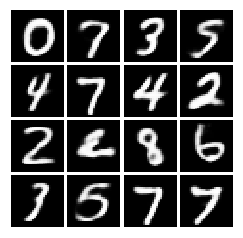

In [31]:
for it in range(100000):
    X, _ = mnist.train.next_batch(mb_size)
    X = torch.from_numpy(X)

    optimizer.zero_grad()

    # forward
    z_mu, z_var = Q(X)
    z = sample_z(z_mu, z_var)
    X_sample = P(z)

    # loss
    recon_loss = F.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1.0 - z_var, 1))
    loss = recon_loss + kl_loss
    
    # backward
    loss.backward()
    
    # update
    optimizer.step()
    
    if it % 1000 == 0:
        print('Iter-{}; Loss: {:.4}'.format(it, loss.item()))
        
        samples = P(z).detach().numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)
        
        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        
        os.makedirs('out', exist_ok=True)
        plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        plt.close(fig)